<a href="https://colab.research.google.com/github/MinsooKwak/Project/blob/main/nlp_project_Day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP | 감성분류 모델

## 0. Background, 시나리오

### 1. 배경

### 2. 시나리오

맞춤형 티 서비스를 제공하는 회사에 데이터사이언티스트로 부임하게 되었다. Tea 회사의 마케팅 팀장은 코로나 이후 매출이 줄어들었다며 새로운 서비스의 제공과 변화가 필요하다 말했다. 이에 나는 코로나라는 위기의 상황을 또 다른 기회로 삼을 수 있을 것이라 가정하며 코로나 상황에서 인간의 감성을 터치할 것을 제안하였다. 자신의 일상을 쉽게 터놓지 못하는 사람들이 자신의 상황을 언어로서 표현하도록 하고 (현재는 글, 추후 음성과 결합 가능) 감성을 분석해 맞춤형 티 서비스를 제공하는 것이다. 이로써 소비자는 자신의 감성을 부수적으로 케어 받을 수 있으며 티 서비스 역시 제공 받을 수 있다. 마케팅 팀장은 아이디어를 받아들였고, 나는 일상대화 데이터를 이용하여 딥러닝을 이용한 감성 분석에 착수했다. 

In [1]:
# 대화 예시 ; 추후 PPT에서 활용해서 대화 카톡형식으로 구성

M: "코로나 이후 매출이 줄어들어 걱정이예요. 매출을 올릴 수 있는 또 다른 서비스와 변화가 필요해요." </br> </br>
DS: "코로나라는 상황이 어려운 상황이지만, 또 기회로 작용할 수 있을 것 같아요.<br> 코로나라는 상황 속에 사람과 사람 사이의 관계의 단절이 발생하는 상황을 활용해보는 건 어떨까요? 
</br> 코로나로 인해 활동량도 줄고 사람간의 관계가 줄어들면서 점차 자신의 감정을 터놓지 못하는 현상이 늘어나고 있어요. 따라서 자신의 상황을 비공개적으로 터놓을 수 있도록 하고, 감성을 분석해 맞춤형 티 서비스를 제공하면 어떨까요?" <br> </br>

### 0. Data import

In [2]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/section4_project/nlp_dataset/감성대화/

/content/drive/MyDrive/section4_project/nlp_dataset/감성대화


In [5]:
import pandas as pd
import numpy as np

In [6]:
pwd

'/content/drive/MyDrive/section4_project/nlp_dataset/감성대화'

In [7]:
ls

AppleGothic.ttf  감성대화말뭉치_Training.xlsx    wordcloud.jpg
results/         감성대화말뭉치_Validation.xlsx


1. Data frame : Train set, validation set

In [8]:
train_dataset = pd.read_excel('감성대화말뭉치_Training.xlsx')

In [9]:
validation_dataset = pd.read_excel('감성대화말뭉치_Validation.xlsx')

In [10]:
print(f'train data shape: {train_dataset.shape} \nvalidation data shape: {validation_dataset.shape}')

train data shape: (40879, 15) 
validation data shape: (5130, 15)


2. Row dataframe 

In [11]:
train_dataset.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [12]:
validation_dataset.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


## 1. 방향성 설정

AI-Hub에서 제공한 말뭉치 대화 데이터셋은 사람과 시스템 사이에 대화 내용이 담긴 데이터셋이다. </br> 연령, 성별, 상황과 신체 질환 여부를 포함하고 있으며 감정에 대한 분류 역시 담겨있다. </br> 또한 대화 상황으로 이뤄져 있으므로 사람과 시스템 응답이 번갈아 차례로 등장하고 있다. </br></br> 먼저, 연령, 성별, 상황키워드, 신체질환여부가 감정과 어떠한 상관성이 있는지 간략하게 파악해볼 것이다. </br> 그리고 본 분석 의도에 따라 상황에 따른 인간의 언어에 대한 감성분석을 목적으로 하기 때문에 </br> 감정과 사람의 문장에 대한 부분 추출하여 사용하고자 한다. 사람의 문장에 대한 부분안 합쳐 사용할 것이다. 

## 2. Dataframe 수정

사람문장과 시스템 문장을 병합해야 하는 이유: </br>
1. 결측치 처리
2. 본 프로젝트의 목적은 문장에 따른 감성분석으로 병합해서 사용해도 무관하다.

### 1) Row dataframe의 결측치 확인 

In [13]:
train_dataset.isnull().sum()

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64

In [14]:
validation_dataset.isnull().sum()

번호           0
연령           0
성별           0
상황키워드        0
신체질환         0
감정_대분류       0
감정_소분류       0
사람문장1        0
시스템응답1       0
사람문장2        0
시스템응답2       0
사람문장3     1256
시스템응답3    1256
사람문장4     4979
시스템응답4    4994
dtype: int64

결측치 제거

--> dropna()를 시도했으나 추후 열들끼리의 병합 과정에서 NAN 처리가 되거나, NAN이 포함된 경우 포함하지 않아 데이터 유출이 발생하는 경우가 생겼다. 방법을 변경하여 na값을 ' '로 변경시켜볼 것이다. 


```
train_dataset.dropna(inplace=True)
validation_dataset.dropna(inplace=True)
```



In [15]:
train_dataset.fillna(' ',inplace=True)
validation_dataset.fillna(' ',inplace=True)
train_dataset.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,,
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,,
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [16]:
train_dataset.isnull().sum()

번호        0
연령        0
성별        0
상황키워드     0
신체질환      0
감정_대분류    0
감정_소분류    0
사람문장1     0
시스템응답1    0
사람문장2     0
시스템응답2    0
사람문장3     0
시스템응답3    0
사람문장4     0
시스템응답4    0
dtype: int64

In [17]:
validation_dataset.isnull().sum()

번호        0
연령        0
성별        0
상황키워드     0
신체질환      0
감정_대분류    0
감정_소분류    0
사람문장1     0
시스템응답1    0
사람문장2     0
시스템응답2    0
사람문장3     0
시스템응답3    0
사람문장4     0
시스템응답4    0
dtype: int64

### 2) 사람문장과 시스템응답을 각기 병합

In [18]:
human_cols = ['사람문장1','사람문장2','사람문장3','사람문장4']
system_cols = ['시스템응답1','시스템응답2','시스템응답3','시스템응답4']

train_dataset['human_document'] =train_dataset[human_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
validation_dataset['human_document']=validation_dataset[human_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

train_dataset['system_document']= train_dataset[system_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
validation_dataset['system_document']= validation_dataset[system_cols].apply(lambda row:' '.join(row.values.astype(str)), axis=1)

In [19]:
train_dataset.isnull().sum()

번호                 0
연령                 0
성별                 0
상황키워드              0
신체질환               0
감정_대분류             0
감정_소분류             0
사람문장1              0
시스템응답1             0
사람문장2              0
시스템응답2             0
사람문장3              0
시스템응답3             0
사람문장4              0
시스템응답4             0
human_document     0
system_document    0
dtype: int64

In [20]:
validation_dataset.isnull().sum()

번호                 0
연령                 0
성별                 0
상황키워드              0
신체질환               0
감정_대분류             0
감정_소분류             0
사람문장1              0
시스템응답1             0
사람문장2              0
시스템응답2             0
사람문장3              0
시스템응답3             0
사람문장4              0
시스템응답4             0
human_document     0
system_document    0
dtype: int64

병합된 feature들 (human_document, system_document)에는 결측치가 없는 것으로 나타났다. </br> 다음으로 필요한 부분만 추출하여 데이터프레임을 구성할 것이다.

### 3) 재구성한 dataframe

In [21]:
train_df = train_dataset[['번호','연령','성별','상황키워드','신체질환','감정_대분류','감정_소분류','human_document','system_document']]
validation_df = validation_dataset[['번호','연령','성별','상황키워드','신체질환','감정_대분류','감정_소분류','human_document','system_document']]

재구성한 train dataframe

In [22]:
train_df.head() 

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,human_document,system_document
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나. 아기가 점점...,아내분이 출산을 하시는군요. 정말 축하드려요. 잘 된 일이네요. 좋은 아빠가 되실 ...
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 ...,약 종류가 많아 번거로우시겠어요. 현재 상황에서 변화를 주기 위해 어떻게 하면 될까...
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 ...,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요. 이 상황에서...
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,재취업 후 첫 월급이라 정말 기쁘시겠어요. 이 기분을 유지하려면 어떻게 해야 할까요...
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. 빚도 다 갚았으니 당분간은 아무...,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요? 빚도 다 갚았으니 당분간은 ...


In [23]:
train_df.shape

(40879, 9)

재구성한 validation dataframe

In [24]:
validation_df.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,human_document,system_document
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀. 난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라...,어떤 일로 부딪히시나요? 부모님과의 충돌로 힘드시겠군요. 자신이 하고 싶은 일을 목...
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼. 엄마도 엄마만의 인생이 있을 테니 가지...,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요? 정말...
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. 그런데 말을 하고 난 후 나...,용기 있는 행동을 하셨네요. 마음이 어떠셨나요? 그랬군요. 지금 기분에서 벗어나기 ...
3,169,청년,남성,"진로, 취업, 직장",해당없음,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이...,팀장님이 부탁하신 업무를 잘못 처리하셔서 많이 당황하시고 놀라셨겠어요. 마음이 많이...
4,38435,중년,여성,"재정, 은퇴, 노후준비",해당없음,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어. 어떻게 그럴 수가 있지...,많이 화가 나시겠어요. 어떻게 하면 지금의 감정을 추스를 수 있을까요? 자녀분들이랑...


In [25]:
validation_df.shape

(5130, 9)

## 3. Understanding Data Set 및 기본 전처리

기존의 데이터가 train data와 validation data로 나눠져 있기 때문에, 전체적인 데이터에 대한 이해를 위해 병합된 데이터셋이 필요하다. </br>
(아래 과정은 데이터를 병합하고 병합한 데이터셋에 대하여 다시 진행한다.)

0. 데이터셋의 크기

In [26]:
df= pd.concat([train_df, validation_df], axis=0, ignore_index=True)

In [27]:
df

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,human_document,system_document
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나. 아기가 점점...,아내분이 출산을 하시는군요. 정말 축하드려요. 잘 된 일이네요. 좋은 아빠가 되실 ...
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 ...,약 종류가 많아 번거로우시겠어요. 현재 상황에서 변화를 주기 위해 어떻게 하면 될까...
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 ...,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요. 이 상황에서...
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. ...,재취업 후 첫 월급이라 정말 기쁘시겠어요. 이 기분을 유지하려면 어떻게 해야 할까요...
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. 빚도 다 갚았으니 당분간은 아무...,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요? 빚도 다 갚았으니 당분간은 ...
...,...,...,...,...,...,...,...,...,...
46004,37859,중년,남성,"재정, 은퇴, 노후준비",해당없음,기쁨,느긋,부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다. 그래서 마음의 안정을 가...,여유롭게 생활할 수 있어 좋으시겠어요. 그렇군요. 계속해서 여유로우려면 어떡해야 좋...
46005,40171,노년,여성,"건강, 죽음",만성질환 유,불안,회의적인,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네? 아직 안 나은 ...,치료가 완료되지 않은 게 아닐까 싶으셔서 염려하고 계시는군요. 많이 불안하시군요. ...
46006,13717,청년,남성,"연애, 결혼, 출산",해당없음,분노,좌절한,연애하고 싶은데 소개팅만 나가면 꽝이야. 이러다가 난 결혼 못 하고 늙어 죽을 거야...,소개팅에서 만나는 사람과 계속 잘 안 풀려서 많이 좌절하신 것 같아요. 댄스 동호...
46007,33784,노년,남성,재정,만성질환 유,분노,안달하는,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해. 당...,은행 대출이 안 돼서 마음이 괴로우시군요. 이 상황을 해결하기 위해서는 어떻게 할 ...


In [28]:
df.shape

(46009, 9)

1. 연령

In [29]:
df.연령.unique() # 전체 데이터셋에 대하여 연령의 구성을 살펴봄

array(['청년', '노년', '청소년', '중년'], dtype=object)

In [30]:
''' 분포 시각적으로 확인하기'''

' 분포 시각적으로 확인하기'

In [31]:
print((df.연령.value_counts(normalize=True)*100).round(2)) # 전체 테이터셋에 대한 연령 분포 확인 #청년 > 중년 > 노년 > 청소년 순

청년     30.55
중년     26.53
노년     24.94
청소년    17.98
Name: 연령, dtype: float64


In [32]:
print((train_df.연령.value_counts(normalize=True)*100).round(2)) # train dataset에 대한 연령 분포 확인 # 전체 분포와 유사

청년     30.59
중년     26.63
노년     24.83
청소년    17.95
Name: 연령, dtype: float64


In [33]:
print((validation_df.연령.value_counts(normalize=True)*100).round(2)) # validation dataset에 대한 연령 분포 확인 # 전체 분포와 유사

청년     30.21
노년     25.81
중년     25.77
청소년    18.21
Name: 연령, dtype: float64


In [34]:
'''
연령 분포를 확인한 결과 구성은 청년, 노년, 중년, 청소년으로 구성되어 있으며,
청년 > 중년> 노년> 청소년 순을 기록하고 있다. '''
### 추가적으로 확인 가능한 사항은 연령별 감정의 분포를 확인할 수 있을 것이다
### 이 경우 metabase를 사용하여 나타낼 수 있다. 

'\n연령 분포를 확인한 결과 구성은 청년, 노년, 중년, 청소년으로 구성되어 있으며,\n청년 > 중년> 노년> 청소년 순을 기록하고 있다. '

2. 성별

In [35]:
print((df.성별.value_counts(normalize=True)*100).round(2)) # 전체 데이터셋에서의 성별 분포 # 여성 > 남성

여성    55.6
남성    44.4
Name: 성별, dtype: float64


In [36]:
print((train_df.성별.value_counts(normalize=True)*100).round(2)) # train dataset에서의 성별 분포 # 여성 > 남성 # 전체 분포와 유사하다.

여성    55.58
남성    44.42
Name: 성별, dtype: float64


In [37]:
print((validation_df.성별.value_counts(normalize=True)*100).round(2)) # validation dataset에서의 성별 분포

여성    55.81
남성    44.19
Name: 성별, dtype: float64


In [38]:
# 적절히 나뉘어졌으므로 분석에 용이하다. 

3. 신체 질환 여부

In [39]:
''' 
신체질환 여부에서의 결과는 다음과 같이 나타난다.
만성질환의 유무에 대해 나타나는 데이터인데, 만성질환 무와 해당없음은 같은 의미를 띄기 때문에 병합하도록 한다. '''
 #  두 가지로 구분되므로 pie chart로 비교할 수 있다.

' \n신체질환 여부에서의 결과는 다음과 같이 나타난다.\n만성질환의 유무에 대해 나타나는 데이터인데, 만성질환 무와 해당없음은 같은 의미를 띄기 때문에 병합하도록 한다. '

In [40]:
print((df.신체질환.value_counts(normalize=True)*100).round(2))

해당없음      75.06
만성질환 무    12.82
만성질환 유    12.12
Name: 신체질환, dtype: float64


In [41]:
# 전체 데이터셋에 대한 신체질환 여부 값 변경
df.loc[(df['신체질환']=='만성질환 무'), '신체질환']=0    # 만성질환 무 = 0
df.loc[(df['신체질환']=='해당없음'), '신체질환']=0 # 해당없음 = 0
df.loc[(df['신체질환']=='만성질환 유'), '신체질환']=1 # 만성질환 유 = 1

# 훈련 데이터셋에 대한 신체질환 여부 값 변경
train_df.loc[(train_df['신체질환']=='만성질환 무'), '신체질환']=0    # 만성질환 무 = 0
train_df.loc[(train_df['신체질환']=='해당없음'), '신체질환']=0 # 해당없음 = 0
train_df.loc[(train_df['신체질환']=='만성질환 유'), '신체질환']=1 # 만성질환 유 = 1

# validation dataset에 대한 신체질환 여부 값 변경
validation_df.loc[(validation_df['신체질환']=='만성질환 무'), '신체질환']=0    # 만성질환 무 = 0
validation_df.loc[(validation_df['신체질환']=='해당없음'), '신체질환']=0 # 해당없음 = 0
validation_df.loc[(validation_df['신체질환']=='만성질환 유'), '신체질환']=1 # 만성질환 유 = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [42]:
print('전체 데이터셋에서\n')
print(f'신체질환이 없음 : {(df.신체질환.value_counts(normalize=True)[0]*100).round(2)}%')
print(f'신체질환이 있음 : {(df.신체질환.value_counts(normalize=True)[1]*100).round(2)}%')

전체 데이터셋에서

신체질환이 없음 : 87.88%
신체질환이 있음 : 12.12%


In [43]:
train_df.신체질환.value_counts(normalize=True)

0    0.878617
1    0.121383
Name: 신체질환, dtype: float64

In [44]:
validation_df.신체질환.value_counts(normalize=True)

0    0.880507
1    0.119493
Name: 신체질환, dtype: float64

In [45]:
### 또 추가적으로 가능한 것은 신체질환의 여부에 따른 감성의 연관성이다. ### 얼마나 영향력이 있는가?

4. 상황 키워드 : 상황 키워드에 관해선 여러개의 키워드가 같은 상황에 함께 존재하는 경우가 있기 때문에 따로 빼주어 분석하도록 한다. 

In [46]:
''' 
1: ,와 ' '기준으로 키워드를 분리
2: 키워드 별 분포 확인 (시각화)'''

sit_keyw_df = df[['번호','상황키워드','감정_대분류']] 
sit_keyw_df

,번호,상황키워드,감정_대분류
0,44164,"연애, 결혼, 출산",기쁨
1,3926,"건강, 죽음",불안
2,50882,학업 및 진로,당황
3,31303,재정,기쁨
4,47200,재정,기쁨
...,...,...,...
46004,37859,"재정, 은퇴, 노후준비",기쁨
46005,40171,"건강, 죽음",불안
46006,13717,"연애, 결혼, 출산",분노
46007,33784,재정,분노


In [47]:
sit_keyw_df.상황키워드.unique()

array(['연애, 결혼, 출산', '건강, 죽음', '학업 및 진로', '재정', '재정, 은퇴, 노후준비', '건강',
       '학교폭력/따돌림', '대인관계', '진로, 취업, 직장', '가족관계', '직장, 업무 스트레스',
       '대인관계(부부, 자녀)'], dtype=object)

In [48]:
'''
어떠한 상황키워드가 있는지 살펴본 결과, 
연애, 결혼, 출산. 건강, 죽음, 학업, 진로, 재정, 은퇴, 노후준비, 학교폭력/따돌림, 대인관계, 취업, 직장, 가족관계, 업무 스트레스, 대인관계(부부,자녀)의 경우로 나타난다.

동일한 종류의 키워드를 다른 형태로 표현해주는 경우가 있기 때문에 유사한 경우는 따로 묶도록 한다.

관계: 연애, 결혼, 학교폭력/따돌림, 대인관계, 가족관계, 대인관계(부부,자녀) 
진로 및 취업: 학업, 진로, 취업, 직장, 업무 스트레스, 
건강: 건강, 
생사: 죽음
생계: 재정, 은퇴, 노후준비 '''
# 위에 내용으로 동일하게 처리해줘야 함 (라벨링 또는 카테고리화 필요)

'\n어떠한 상황키워드가 있는지 살펴본 결과, \n연애, 결혼, 출산. 건강, 죽음, 학업, 진로, 재정, 은퇴, 노후준비, 학교폭력/따돌림, 대인관계, 취업, 직장, 가족관계, 업무 스트레스, 대인관계(부부,자녀)의 경우로 나타난다.\n\n동일한 종류의 키워드를 다른 형태로 표현해주는 경우가 있기 때문에 유사한 경우는 따로 묶도록 한다.\n\n관계: 연애, 결혼, 학교폭력/따돌림, 대인관계, 가족관계, 대인관계(부부,자녀) \n진로 및 취업: 학업, 진로, 취업, 직장, 업무 스트레스, \n건강: 건강, \n생사: 죽음\n생계: 재정, 은퇴, 노후준비 '

5. 감정: 대분류

In [49]:
df.감정_대분류.unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처', '불안 ', '기쁨 '], dtype=object)

In [50]:
# 전체 데이터셋에 대한 감정대분류 값 수정
df.replace('기쁨 ','기쁨', inplace=True)
df.replace('불안 ','불안', inplace=True)

# train_df에 대한 감정대분류 값 수정
train_df.replace('기쁨 ','기쁨', inplace=True)
train_df.replace('불안 ','불안', inplace=True)

# validation_df에 대한 감정대분류 값 수정
validation_df.replace('기쁨 ','기쁨', inplace=True)
validation_df.replace('불안 ','불안', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


감정대분류값이 잘 바뀌었는지 확인

In [51]:
df.감정_대분류.unique() # 전체 데이터셋에 대한 감정대분류값이 잘 바뀌었는지 확인

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [52]:
train_df.감정_대분류.unique() # train dataset 감정대분류 값이 원활히 바뀌었는지 확인

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [53]:
validation_df.감정_대분류.unique() # validation dataset 감정대분류 값이 잘 바뀌었는지 확인

array(['분노', '슬픔', '불안', '당황', '상처', '기쁨'], dtype=object)

--> 전체, train, validation dataset에서 감정 대분류 값이 잘 변형되었음을 확인할 수 있다. 

In [54]:
print((df.감정_대분류.value_counts(normalize=True)*100).round(2))

불안    17.90
분노    16.94
슬픔    16.90
기쁨    16.46
상처    16.17
당황    15.63
Name: 감정_대분류, dtype: float64


In [55]:
print((train_df.감정_대분류.value_counts(normalize=True)*100).round(2))

불안    17.93
분노    16.93
슬픔    16.92
기쁨    16.47
상처    16.20
당황    15.56
Name: 감정_대분류, dtype: float64


In [56]:
print((validation_df.감정_대분류.value_counts(normalize=True)*100).round(2))

불안    17.68
분노    17.02
슬픔    16.78
기쁨    16.39
당황    16.22
상처    15.91
Name: 감정_대분류, dtype: float64


--> 확인 결과 감정_대분류의 분포가 유사하므로 모델링을 진행하기에 적합한 데이터셋임을 확인할 수 있었다. </br>
--> 감정_대분류 카데코리가 타겟값이 될 것이다.

In [57]:
print(df.감정_소분류.unique()) 
'''
소분류로 진행하기엔 카테고리가 너무 많다. 
더 구체적인 서비스를 제공하고 싶을 경우 용이하지만 타켓 카테고리값이 너무 커지므로 확률값에 영향이 있을 것이라 생각되었다. 
추후 진행 고려 가능 '''

['신이 난' '스트레스 받는' '당황' '안도' '취약한' '우울한' '구역질 나는' '좌절한' '눈물이 나는' '배신당한'
 '남의 시선을 의식하는' '죄책감의' '당혹스러운' '분노' '두려운' '낙담한' '회의적인' '마비된' '혼란스러운' '흥분'
 '한심한' '염세적인' '안달하는' '걱정스러운' '조심스러운' '충격 받은' '상처' '불안' '노여워하는' '기쁨' '짜증내는'
 '환멸을 느끼는' '비통한' '혐오스러운' '억울한' '만족스러운' '부끄러운' '버려진' '고립된' '괴로워하는' '자신하는'
 '외로운' '방어적인' '편안한' '질투하는' '감사하는' '초조한' '실망한' '슬픔' '신뢰하는' '가난한, 불우한'
 '후회되는' '툴툴대는' '성가신' '열등감' '희생된' '느긋' '악의적인']


'\n소분류로 진행하기엔 카테고리가 너무 많다. \n더 구체적인 서비스를 제공하고 싶을 경우 용이하지만 타켓 카테고리값이 너무 커지므로 확률값에 영향이 있을 것이라 생각되었다. \n추후 진행 고려 가능 '

## 4. 모델링 사전 준비_1

### 데이터프레임 결측치 재확인

In [58]:
df.isnull().sum()

번호                 0
연령                 0
성별                 0
상황키워드              0
신체질환               0
감정_대분류             0
감정_소분류             0
human_document     0
system_document    0
dtype: int64

In [59]:
train_df.isnull().sum()

번호                 0
연령                 0
성별                 0
상황키워드              0
신체질환               0
감정_대분류             0
감정_소분류             0
human_document     0
system_document    0
dtype: int64

In [60]:
validation_df.isnull().sum()

번호                 0
연령                 0
성별                 0
상황키워드              0
신체질환               0
감정_대분류             0
감정_소분류             0
human_document     0
system_document    0
dtype: int64

### 모델링용 데이터프레임 형성

감정_대분류, human_document 부분만 추출하여 사용하도록 한다. </br>
여기서는 인간이 사용한 문장에 대한 감성분석이 목적이므로, 시스템 응답 부분인 system document는 배제하겠다. 

In [61]:
for_train = train_df[['감정_대분류','human_document']]
for_validation = validation_df[['감정_대분류','human_document']]

In [62]:
for_train.head(3)

,감정_대분류,human_document
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나. 아기가 점점...
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 ...
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 ...


In [63]:
for_validation.head(3)

,감정_대분류,human_document
0,분노,요즘 부모님과 많이 부딪혀. 난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라...
1,슬픔,엄마가 결국 집을 나갔어. 너무 너무 슬퍼. 엄마도 엄마만의 인생이 있을 테니 가지...
2,불안,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. 그런데 말을 하고 난 후 나...


### 일상대화에서 활용된 단어 분포 시각화 (Wordcloud 활용) : Row Data

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

In [65]:
# 한글폰트 준비
urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf")

('AppleGothic.ttf', <http.client.HTTPMessage at 0x7f868a68c0d0>)

분석을 위한 불용어 제거 및 토큰화


In [66]:
'''
Spacy의 경우 한글 토큰화를 지원하고 있지 않기 때문에 다른 방안을 사용해야 한다. '''

'\nSpacy의 경우 한글 토큰화를 지원하고 있지 않기 때문에 다른 방안을 사용해야 한다. '

In [67]:
# Stopwords를 위한 준비
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('nan')
stopwords.add('내가')
# 불용어 추가시 : stopwords.add('')
tokenized_text = []

In [68]:
stopwords2 = ['같아','거야','오늘','내일','계속','많이','그래서','그렇게','친구들이','것','내가','같아','내','수','게','나는','하고','친구가','그','한','거','다','나',
              '지금','건','나만','돼.','나한테','남편이','돈이','것이','이번에','회사','회사에서','나에게','아들이','친구에게','친구를','중이야.','매일','대해','사람들이',
              '돈','엄마가','딸이','어제','직장','얼마','친구들과','해도','번','일','회사에','운동을','공부를','시간을','그동안','부모님이','하나','몇','나의','나랑','시간이',
              '어떤','아빠가','학교','자식들이','아내와','자기','친구한테','나와','나이','친구랑','학교에서','아내에게','여자','친구들에게','건강','친구는','집에서','직장에서',
              '취업','자식들에게','김','남편과','후','집','친구들','남자','애들이','오늘은','전','회사를','두','집을','음식을','데','엄마한테','회사가','남편에게','직장을',
              '가족들과','온','엄마','요즘은','가족들에게','여자친구가','친구들이랑','옆집','아들에게','달','간','동료가','밥','아내를','친구들한테','부모님','직언이','사','삼',
              '아내','박','아내의','엄마랑','몸에','프로젝트를','의사','나에','아빠는','알','올','할머니가','하다','아이','남편이랑','중','드는','돈은','저녁에','아들과',
              '남편','아들','엄마는','학교에','의사가','아이들이','딸에게','자식들은','씨가','같아.','해.','거야','나를','나.','응.','하는','나도','요즘','거야','아내가']

In [69]:
stopwords.update(stopwords2) # update함수 : 여러개의 값을 한 번에 추가

분석을 위한 기본 불용어 제거 후 시각화 (WordCloud)

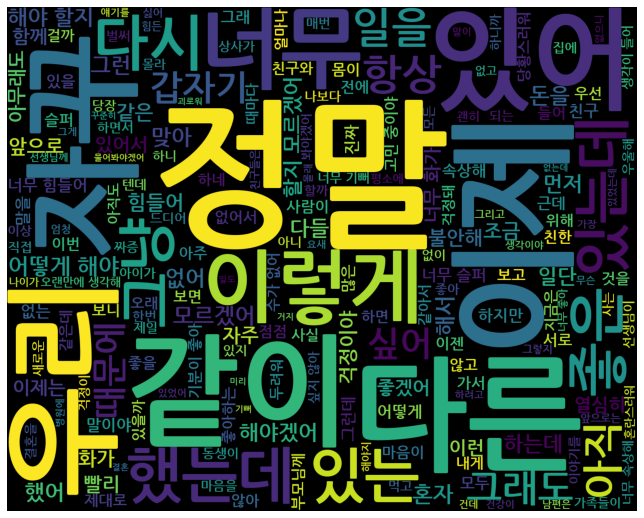

In [70]:
for val in df['human_document']:

  # 문장을 string 형식으로 변환
  val = str(val)

  # 문장 토큰화
  tokens = val.split()

  tokenized_text.append(tokens) # 위에서 만들어 놓은 tokenized_text에 tokens 더함
  comment_words += " ".join(tokens)+" " # 위에서 만들어놓은 comment_words에 tokens 결합

wordcloud = WordCloud(width=1500, height=1200,
                      font_path = 'AppleGothic.ttf',
                      background_color ='black',
                      stopwords = stopwords,
                      min_font_size=10).generate(comment_words) # color_map은 unexpected 되서 일단 제거해줌 #Set2

# plot WordCloud image
plt.figure(figsize=(10,7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [71]:
wordcloud.to_file('wordcloud.jpg') # 위에 생성한 wordcloud를 파일로 저장 # .to_file()

In [72]:
tokenized_text[0] # tokenized_text가 잘 형성되었는지 확인

['아내가',
 '드디어',
 '출산하게',
 '되어서',
 '정말',
 '신이',
 '나.',
 '아',
 '지금',
 '정말',
 '신이',
 '나.',
 '아기가',
 '점점',
 '클게',
 '벌써',
 '기대가',
 '되네.',
 '내가',
 '많이',
 '놀아줘야지.']

In [73]:
print(f'토큰화된 문장은 총 {len(tokenized_text)}개이다.')

토큰화된 문장은 총 46009개이다.


In [74]:
# 불용어 필터 함수 형성
def filter_stopwords(tokenized_text, stopword2):
  '''
  토큰화된 텍스트에 새로 추가 할 불용어 리스트를 추가한다.
  '''
  tokenized_filtered =[] # 불용어 필터 리스트 생성

  for i in tokenized_text: # 토큰화된 텍스트를 순차적으로
    for word in i:  # 토큰화된 텍스트 안의 단어가
      if word not in stopwords: # 만약 stopword가 아니면,
        tokenized_filtered.append(word) # 불용어 필터 리스트에 단어를 추가해준다

  return tokenized_filtered

In [75]:
# 위에서 정의한 불용어 필터 함수를 적용
tokenized_filtered = filter_stopwords(tokenized_text, stopwords2)

tokenized_filtered[0:10] #10개 출력해보기

['드디어', '출산하게', '되어서', '정말', '신이', '아', '정말', '신이', '아기가', '점점']

--> 불용어가 제거되었음을 확인할 수 있다.

In [76]:
print(f'불용어 필터를 적용한 후의 토큰의 개수는 {len(tokenized_filtered)}개 이다.')

불용어 필터를 적용한 후의 토큰의 개수는 979553개 이다.


정제한 토큰을 시각화


- import operator를 통해 연산하는 방식과 collections의 Counter를 불러와 연산하는 방식 중에 고민했음 </br>
  --> import operator 방식을 적용해보겠음
  --> Bert를 사용할 것인데 문장을 넣어줘야 함

In [77]:
import operator

def word_count(tokenized_data):
  word_counter ={}

  for i in tokenized_data:
    if i in word_counter.keys():
      word_counter[i] += 1
    else:
      word_counter[i] =1
  
  sorted_dict = dict(sorted(word_counter.items(),
                            key=operator.itemgetter(1), reverse=True))
  return sorted_dict

In [78]:
tokenized_dict = word_count(tokenized_filtered)

In [79]:
# 상위 30개 단어 추출
def top_30(tokenized_dict):
  top_30_words = list(tokenized_dict.items())[:30] # 딕셔너리(dictionary)는 items()함수: 딕셔너리에 있는 키와 값들의 쌍을 얻을 수 있음
  return top_30_words

In [80]:
top_30(tokenized_dict)

[('너무', 16363),
 ('안', 9194),
 ('더', 6269),
 ('잘', 5642),
 ('정말', 4729),
 ('할', 4382),
 ('못', 3926),
 ('거야.', 3897),
 ('어떻게', 3531),
 ('모르겠어.', 3388),
 ('싶어.', 3362),
 ('좀', 3184),
 ('있는', 3069),
 ('때문에', 3038),
 ('다른', 3038),
 ('해서', 3032),
 ('있어.', 2780),
 ('열심히', 2740),
 ('우리', 2713),
 ('화가', 2604),
 ('좋은', 2581),
 ('없어.', 2525),
 ('왜', 2492),
 ('해야', 2454),
 ('이제', 2273),
 ('난', 2268),
 ('않아.', 2195),
 ('이', 2190),
 ('일을', 2186),
 ('같이', 2176)]

In [81]:
#상위 10개 단어 추출
def top_10(tokenized_dict):
  top_10_words = list(tokenized_dict.items())[:10]
  return top_10_words

top10 = top_10(tokenized_dict)

In [82]:
!pip install squarify

In [83]:
top10_df = pd.DataFrame(top10)
top10_df

,0,1
0,너무,16363
1,안,9194
2,더,6269
3,잘,5642
4,정말,4729
5,할,4382
6,못,3926
7,거야.,3897
8,어떻게,3531
9,모르겠어.,3388


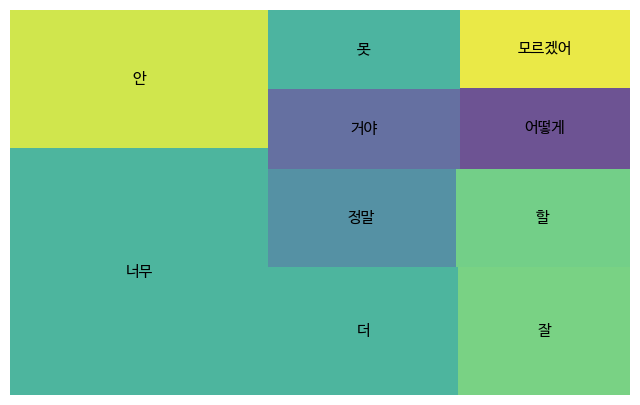

In [84]:
import squarify
plt.style.use('default')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 11
plt.rc('font', family='NanumBarunGothic') 

sizes = [14557,8165,5568,5020,4230,3932,3505,3485,3143,3019]
labels = ['너무','안','더','잘','정말','할','거야','못','어떻게','모르겠어']

plt.axis('off')
squarify.plot(sizes, label=labels, alpha=0.8)
plt.show()

### BERT 모델 사용 전 준비

BERT에 사용할 모듈 import

In [85]:
!pip install transformers

In [86]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [87]:
import random
import time
import datetime 

BERT 활용을 위한 GPU

In [88]:
# colab을 사용할 것이기 때문에 colab 내부 GPU를 활용해볼 것임
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
  print(torch.cuda.get_device_name(i))

1
Tesla K80


## BERT 모델링 사전 준비

BERT는 양뱡향성 모델로 Foward, Backward 방식으로 propagate를 수행한다. Context 안에 이전 정보와 다음 단어에 대한 정보가 반영이 될 경우가 더 예측에 더 용이하다. 자연어처리 부문에서 2018년 Bert가 등장한 이후 유명세를 들어보았기 때문에 CNN의 방법이나 다른 모델 대신 Bert를 사용하게 되었다. 한국어 토큰화를 시행해야 하기 때문에 KOBERT를 사용해야 하나 고민하였으나 BERT를 사용할 수 있음을 확인하고 BERT를 사용하게 되었다.

[Bert를 잘 설명하고 있는 글](https://www.quantumdl.com/entry/12%EC%A3%BC%EC%B0%A82-BERT-Pre-training-of-Deep-Bidirectional-Transformers-for-Language-Understanding)을 첨부하였다. </br></br>
또 참고한 자료: </br>
- [Bert 이진분류](http://yonghee.io/bert_binary_classification_naver/)

### 0. Bert에 맞는 Tag 달기

In [89]:
bert_text = []

for i in for_train['human_document']:
  bert = ["[CLS] "+str(i)+" [SEP]"]
  bert_text.append(bert)

In [90]:
bert_text[:5]

[['[CLS] 아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나. 아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.    [SEP]'],
 ['[CLS] 당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 관리 좀 잘할걸 하는 생각이 들더라고. 약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.   [SEP]'],
 ['[CLS] 고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼. 중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야. 선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해. [SEP]'],
 ['[CLS] 재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. 퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 수 있어서 너무 행복해. 회사생활을 열심히 해서 계속 월급을 받을거야!   [SEP]'],
 ['[CLS] 빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. 빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.     [SEP]']]

토큰화가 되지 않은 document를 넣어주었고, [CLS]와 [SEP] 사이에 문장이 들어가 있음을 발견할 수 있다. 시작과 끝을 나타낸다. </br>
같은 상황 속에 발생하였기 때문에 따로 분리해주지 않고 그대로 진행했다.

In [91]:
# validation dataset에도 Tag 달기
val_text = []

for i in for_validation['human_document']:
  bert = ["[CLS] "+str(i)+" [SEP]"]
  val_text.append(bert)

In [92]:
val_text[:5]

[['[CLS] 요즘 부모님과 많이 부딪혀. 난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도 못해. 응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.   [SEP]'],
 ['[CLS] 엄마가 결국 집을 나갔어. 너무 너무 슬퍼. 엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 답답해. 일단 좀 자야겠어.   [SEP]'],
 ['[CLS] 학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어. 그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어. 나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.   [SEP]'],
 ['[CLS] 이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야. 곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아. 우선 잘못된 부분을 솔직하게 말씀드리고 수정하기 위해서 최선을 다해봐야겠어.   [SEP]'],
 ['[CLS] 남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어. 어떻게 그럴 수가 있지? 너무 화가 나. 나도 변호사를 고용해서 한번 얘기해보려고 해.   [SEP]']]

### 1. Bert multillingual 모델에 있는 tokenizer 활용하여 토큰화

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)

In [94]:
print(tokenized_data[0:3])

[['[CLS]', '아', '##내', '##가', '드', '##디', '##어', '출', '##산', '##하게', '되어', '##서', '정', '##말', '신', '##이', '나', '.', '아', '지', '##금', '정', '##말', '신', '##이', '나', '.', '아', '##기가', '점', '##점', '클', '##게', '벌', '##써', '기', '##대가', '되', '##네', '.', '내', '##가', '많이', '놀', '##아', '##줘', '##야', '##지', '.', '[SEP]'], ['[CLS]', '당', '##뇨', '##랑', '합', '##병', '##증', '때문에', '먹', '##어', '##야', '할', '약', '##이', '열', '가지', '##가', '넘', '##어', '##가', '##니', '##까', '스', '##트', '##레스', '##야', '.', '건', '##강', '##할', '때', '관', '##리', '좀', '잘', '##할', '##걸', '하는', '생', '##각', '##이', '들', '##더', '##라고', '.', '약', '##을', '잘', '챙', '##겨', '먹', '##고', '나', '##을', '수', '있도록', '노', '##력', '##해야', '##지', '.', '[SEP]'], ['[CLS]', '고', '##등학교', '##에', '올', '##라', '##오', '##니', '중', '##학교', '때', '##보다', '수', '##업', '##이', '갑', '##자', '##기', '어', '##려', '##워', '##져', '##서', '당', '##황', '##스', '##러', '##워', '.', '아', '##직', '학', '##기', '초', '##인', '##데', '내', '##가', '수', '##업', '##에', '잘', '따라', '##갈', '수', '있을', '#

In [95]:
tokenized_val_data =[]
for i in val_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_val_data.append(tokens)

In [96]:
print(tokenized_val_data[0:3])

[['[CLS]', '요', '##즘', '부', '##모', '##님', '##과', '많이', '부', '##딪', '##혀', '.', '난', '하고', '싶', '##은', '일', '##이', '있는데', '부', '##모', '##님', '##은', '안', '##정', '##적인', '일', '##만', '하', '##라고', '하', '##셔', '.', '내', '마', '##음', '##대로', '하지', '##도', '못', '##해', '.', '응', '.', '그', '##래', '##도', '난', '내', '##가', '하고', '싶', '##은', '일을', '위해', '노', '##력', '##할', '거', '##야', '.', '[SEP]'], ['[CLS]', '엄', '##마', '##가', '결국', '집', '##을', '나', '##갔', '##어', '.', '너', '##무', '너', '##무', '슬', '##퍼', '.', '엄', '##마', '##도', '엄', '##마', '##만', '##의', '인', '##생', '##이', '있을', '테', '##니', '가지', '말', '##라고', '할', '수', '##가', '없', '##었', '##어', '.', '그', '##래', '##서', '더', '마', '##음', '##이', '답', '##답', '##해', '.', '일', '##단', '좀', '자', '##야', '##겠', '##어', '.', '[SEP]'], ['[CLS]', '학', '##교', '##에서', '한', '친', '##구를', '괴', '##롭', '##히', '##는', '무', '##리에', '##게', '그', '##만', '##하라', '##고', '했', '##어', '.', '그', '##런', '##데', '말', '##을', '하고', '난', '후', '나', '##도', '괴', '##롭', '##힐', '##까', '봐', '불', '#

tokenizer를 통해 token화된 결과에서 ##이 붙은 결과가 나타난다. 이는 subword라는 해결책을 사용했기 때문인데, 토큰화의 가장 큰 문제점이 OOV 문제였다. OOV를 해결하기 위해 단어사전을 만들기도 하는데, 위에서 토큰화를 진행했듯 굉장한 노동력이 필요하다. Subword 방식에는 wordpiece, byte pair encoding 등 다양한 방식이 있다한다. Bert논문에서는 wordpiece 방식을 사용하고 있는데, 한국어 모델을 사용하기 위해서 bert multilingual 모델을 사용해야 한다고 한다. [참조](https://ai-information.blogspot.com/2019/04/bert-embedding.html) 토큰들이 <unk>처리가 된다고 한다. 따라서 bert multilingual 모델 내부의 tokenizer를 사용하였고, 토큰화가 된 것을 확인할 수 있다.

### 2. padding 작업 진행

가장자리의 정보들을 잘 활용하기 위해 패딩을 진행한다. 또한 기계는 동일한 길이의 문서들에 대해 하나의 행렬로 보고 한 번에 처리할 수 있다. 

1) 정수로 인코딩 : tokenizer.convert_tokens_to_ids()

    tokenizer.convert_tokens_to_ids(): token string 또는 token string의 리스트를 token id 또는 Token id의 리스트로 변환하는 함수

In [97]:
# 먼저 train 데이터를 정수로 인코딩
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

In [98]:
# val 데이터 역시 정수로 인코딩
input_val_ids = []
for i in tokenized_val_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_val_ids.append(ids)

2) 길이 제한 및 패딩 처리 : pad_sequences() </br>
- maxlen 설정

In [99]:
print(input_ids[0]) #train 패딩 영역 점검(확인)

[101, 9519, 31605, 11287, 9113, 48446, 12965, 9768, 21386, 17594, 37909, 12424, 9670, 89523, 9487, 10739, 8982, 119, 9519, 9706, 40032, 9670, 89523, 9487, 10739, 8982, 119, 9519, 47869, 9668, 34907, 9836, 14153, 9339, 73131, 8932, 97048, 9098, 77884, 119, 8996, 11287, 47058, 9025, 16985, 119221, 21711, 12508, 119, 102]


In [100]:
print(input_val_ids[0]) #val 패딩 영역 점검(확인)

[101, 9599, 119229, 9365, 39420, 108578, 11882, 47058, 9365, 118824, 80579, 119, 8984, 32487, 9495, 10892, 9641, 10739, 60030, 9365, 39420, 108578, 10892, 9521, 16605, 15387, 9641, 19105, 9952, 59894, 9952, 119049, 119, 8996, 9246, 32158, 37601, 89093, 12092, 9290, 14523, 119, 9636, 119, 8924, 37388, 12092, 8984, 8996, 11287, 32487, 9495, 10892, 110149, 19905, 9022, 28143, 14843, 8863, 21711, 119, 102]


In [101]:
max_len = 128 # 설정한 max_len만큼 빈 공간을 0으로 채운다.
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post',padding='post') # 문장길이 제한 및 패딩 # truncating: remove values from sequences larger than maxlen

In [102]:
input_ids[0] # 패딩이 잘 완료되었는지 확인. 빈 공간 0으로 채워졌나

array([   101,   9519,  31605,  11287,   9113,  48446,  12965,   9768,
        21386,  17594,  37909,  12424,   9670,  89523,   9487,  10739,
         8982,    119,   9519,   9706,  40032,   9670,  89523,   9487,
        10739,   8982,    119,   9519,  47869,   9668,  34907,   9836,
        14153,   9339,  73131,   8932,  97048,   9098,  77884,    119,
         8996,  11287,  47058,   9025,  16985, 119221,  21711,  12508,
          119,    102,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [103]:
# val에도 패딩 진행
input_val_ids = pad_sequences(input_val_ids, maxlen=max_len, dtype='long', truncating='post', padding='post') 

In [104]:
input_val_ids[0] # val에도 패딩이 잘 완료되었는지 확인. 빈 공간 0으로 채워졌나

array([   101,   9599, 119229,   9365,  39420, 108578,  11882,  47058,
         9365, 118824,  80579,    119,   8984,  32487,   9495,  10892,
         9641,  10739,  60030,   9365,  39420, 108578,  10892,   9521,
        16605,  15387,   9641,  19105,   9952,  59894,   9952, 119049,
          119,   8996,   9246,  32158,  37601,  89093,  12092,   9290,
        14523,    119,   9636,    119,   8924,  37388,  12092,   8984,
         8996,  11287,  32487,   9495,  10892, 110149,  19905,   9022,
        28143,  14843,   8863,  21711,    119,    102,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [105]:
input_val_ids.shape

(5130, 128)

### 3. 마스킹 처리: attention masks (MLM: Masked Language Model) </br>

BERT는 마스킹된 언어모델로, 입력으로 사용하는 문장의 토큰중 15%의 확률로 선택된 토큰을 [MASK] 토큰으로 변환시키고, 언어모델을 통해 변환되기전 [MASK] 토큰을 예측하는 언어모델 [(참고)](https://velog.io/@nawnoes/%EB%82%98%EB%A7%8C%EC%9D%98-%EC%96%B8%EC%96%B4%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-Masked-Language-Model-%ED%95%99%EC%8A%B5) </br>
- 인코딩된 토큰 시퀀스에서 패딩(0)에 해당하는 부분은 0, 패딩이 아닌 부분은 1로 간주하는 마스크를 생성 
- 0 값을 가지는 패딩 토큰에 대해 어텐션 연산을 불필요하게 수행하지 않도록 함
- 학습 속도가 향상되는 효과

In [106]:
# 빈 attention mask 형성
attention_masks =[]

for ids in input_ids: # 패딩한 데이테셋 내부를 순환하면서
  ids_mask = []
  for id in ids:
    masked = float(id>0) # id>0 인 데이터를 마스크로 씌우고
    ids_mask.append(masked) # 불필요한 계산을 하지 않도록 마스크를 씌움
  attention_masks.append(ids_mask)

In [107]:
print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


mask를 씌우면서 attention_val_masks가 아닌 attention_test_masks로 생성한 이유는 </br> 이후 train, val, test dataset으로 나눠 훈련을 진행할 것이기 때문이다.

In [108]:
# validation dataset에도 적용
attention_test_masks = [] 

for ids in input_val_ids:
  ids_test_mask = []
  for id in ids:
    masked = float(id>0)
    ids_test_mask.append(masked)
  attention_test_masks.append(ids_test_mask)

print(attention_test_masks[0])
print(len(attention_test_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


### 4. 라벨 인코딩: 정수로 변환

In [109]:
 for_train.감정_대분류.unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [110]:
for_validation.감정_대분류.unique()

array(['분노', '슬픔', '불안', '당황', '상처', '기쁨'], dtype=object)

In [111]:
# train dataset label 변경
for_train.loc[(for_train['감정_대분류']=='당황'), '감정_대분류']=0    # 당황 = 0
for_train.loc[(for_train['감정_대분류']=='슬픔'), '감정_대분류']=1    # 슬픔 = 1
for_train.loc[(for_train['감정_대분류']=='기쁨'), '감정_대분류']=2    # 기쁨 = 2
for_train.loc[(for_train['감정_대분류']=='불안'), '감정_대분류']=3    # 불안 = 3
for_train.loc[(for_train['감정_대분류']=='상처'), '감정_대분류']=4    # 상처 = 4
for_train.loc[(for_train['감정_대분류']=='분노'), '감정_대분류']=5    # 분노 = 5

# validation dataset label 변경
for_validation.loc[(for_validation['감정_대분류']=='당황'), '감정_대분류']=0    # 당황 = 0
for_validation.loc[(for_validation['감정_대분류']=='슬픔'), '감정_대분류']=1    # 슬픔 = 1
for_validation.loc[(for_validation['감정_대분류']=='기쁨'), '감정_대분류']=2    # 기쁨 = 2
for_validation.loc[(for_validation['감정_대분류']=='불안'), '감정_대분류']=3    # 불안 = 3
for_validation.loc[(for_validation['감정_대분류']=='상처'), '감정_대분류']=4    # 상처 = 4
for_validation.loc[(for_validation['감정_대분류']=='분노'), '감정_대분류']=5    # 분노 = 5

# 전체 데이터셋에 대한 label 변경 (만일을 대비해 변경)
df.loc[(df['감정_대분류']=='당황'), '감정_대분류']=0    # 당황 = 0
df.loc[(df['감정_대분류']=='슬픔'), '감정_대분류']=1    # 슬픔 = 1
df.loc[(df['감정_대분류']=='기쁨'), '감정_대분류']=2    # 기쁨 = 2
df.loc[(df['감정_대분류']=='불안'), '감정_대분류']=3    # 불안 = 3
df.loc[(df['감정_대분류']=='상처'), '감정_대분류']=4    # 상처 = 4
df.loc[(df['감정_대분류']=='분노'), '감정_대분류']=5    # 분노 = 5

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

In [112]:
for_train.감정_대분류.value_counts(normalize=True) #분포가 유사함

3    0.179285
5    0.169280
1    0.169158
2    0.164657
4    0.162039
0    0.155581
Name: 감정_대분류, dtype: float64

In [113]:
for_validation.감정_대분류.value_counts(normalize=True)

3    0.176803
5    0.170175
1    0.167836
2    0.163938
0    0.162183
4    0.159064
Name: 감정_대분류, dtype: float64

In [114]:
for_train.head(3)

,감정_대분류,human_document
0,2,아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나. 아기가 점점...
1,3,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 ...
2,0,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 ...


### 5. 모델링을 위해 train, val, test dataset으로 분리

- 패딩된 데이터셋과 train 데이터셋의 감정_대분류 라벨을 X_train,X_val, y_train, y_val로 분리 
- validation 비율은 0.2

In [115]:
X_train, X_val, y_train, y_val = train_test_split(input_ids,for_train['감정_대분류'].values, random_state=42, test_size=0.2)

In [116]:
input_ids.shape

(40879, 128)

In [117]:
for_train['감정_대분류'].shape

(40879,)

마스킹 역시 train과 val에 맞춰 분리해준다. 

In [118]:
len(attention_masks)

40879

In [119]:
print(len(attention_masks[0]))

128


for_validation의 경우도 shape 변경을 시켜준다.

---
```
 train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2) 
```
그냥 실시할 시 아래와 같은 오류 메세지가 발생했다. 


> ValueError: Found input variables with inconsistent numbers of samples: [5232512, 40879]



이는 연산되는 사이즈의 크기가 적합하지 않았기 때문인데, 이를 맞추기 위해 attention mask 리스트를 np의 n차원 배열로 변환시켜줬다. attention mask의 사이즈 조정을 위해 np.array로 변경된 마스크에 reshape 함수를 이용하여 사이즈를 맞춰주었다. 

```
reshape(40879,-1)
```
**attention masks에 대하여** </br>
5232512 길이의 리스트를 연산될 40879와 맞춰줘야 하며, 정확한 길이를 알지 못하기 때문에 열에 -1값을 입력하여 shape를 맞춰주었다. </br>

**attention_test_masks에 대하여**</br>
동일하게 패딩된 데이터셋 shape에 맞춰준다.</br>

---

In [120]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2) 

In [121]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32703, 128), (8176, 128), (32703,), (8176,))

In [122]:
# Fine-tuning과 Tensor로 사용할 데이터 분리
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

In [123]:
X_test_tensor = input_val_ids
y_test_tensor = for_validation['감정_대분류'].values
test_masks = attention_test_masks

In [124]:
y_test_tensor.shape

(5130,)

### 6. Pytorch로 변경하기
패딩한 데이터인 input_ids, 타겟 라벨, masking을 PyTorch로 변환시켜야 한다.</br>
PyTorch를 이용해 프로세스를 진행하려면 tensor로 변환해서 네트워크에 넣어주어야 한다. [(관련 자료)](https://anweh.tistory.com/10)</br>

torch.tensor()는 데이터를 tensor로 copy해주는 함수이다. (torch.Tensor와 다름)

In [125]:
# train data에 대한 PyTorch 변환
X_train_tensor = torch.tensor(X_train)
y_train = np.array(y_train,dtype=np.float)
y_train_tensor = torch.from_numpy(y_train)
train_masks = torch.tensor(train_masks)

# validation data에 대한 PyTorch 변환
X_val_tensor = torch.tensor(X_val)
y_val = np.array(y_val,dtype=np.float)
y_val_tensor = torch.from_numpy(y_val)
validation_masks = torch.tensor(validation_masks)

In [126]:
# test dataset
X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = np.array(y_test_tensor, dtype=np.float)
y_test_tensor = torch.from_numpy(y_test_tensor)
test_masks = torch.tensor(attention_test_masks)

### batch size 조정

Dataset으로 유의미한 data를 뽑아오기 위한 것이 DataLoader라 한다.[(자료)](https://hulk89.github.io/pytorch/2019/09/30/pytorch_dataset/) </br>
DataLoader함수를 이용해, 배치크기나 데이터를 섞을지 여부 등을 결정해주기 위해 TensorDasaset으로 정의한다. </br>
- 더 안정적으로 학습을 수행할 수 있음 </br>
[(관련 자료: PyTorch의 Dataset과 DataLoader를 이용하여 학습 효율성 향상)](http://www.gisdeveloper.co.kr/?p=8615)
- batch_size는 4의 배수 단위로 설정하는 것이 컴퓨터에게 부담이 덜 간다고 한다. </br>
----
RandomSampler()를 통해 데이터를 랜덤하게 가져온다. </br>
SequentialSampler() : 항상 같은 순서

**TensorDataset으로 저장**

In [127]:
X_train_tensor.shape

torch.Size([32703, 128])

In [128]:
train_masks.shape

torch.Size([32703, 128])

In [129]:
y_train_tensor.shape

torch.Size([32703])

In [130]:
X_test_tensor.shape

torch.Size([5130, 128])

In [131]:
test_masks.shape

torch.Size([5130, 128])

In [132]:
y_test_tensor.shape

torch.Size([5130])

In [133]:
batch_size =32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks,y_val_tensor)
val_sampler = SequentialSampler(val)

test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

---
패딩된 데이터셋 shape에 맞춰야 하는 이유: 
```
test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)
```
를 패딩된 shape가 아닌 패딩 전 dataset에 맞출 경우 아래와 같은 에러가 발생하므로, shape을 반영하여 다시 설정해준다. 

```
AssertionError: Size mismatch between tensors
```
X_val_tensor의 shape와 validation_masks의 연산을 위해 shape을 확인해보면, </br>
[8176,128], (8176,0) 으로 연산이 가능한 형태이다. </br></br>
X_test_tensor의 shape와 test_masks의 shape를 연산 가능한 형태로 변환시켜주었다.</br>
[40879,128], (5130, 0) --> [40879,128], (40879, 0)

---

---
**DataLoader**

In [134]:
train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

**GPU / CPU**

In [135]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are %d GPU(s) available"% torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("No GPU available. Using CPU instead.")

# GPU 사용시 설정

There are 1 GPU(s) available
We will use the GPU: Tesla K80


## BERT modeling

### 분류를 위한 BERT model 생성 | BertForSequenceClassification model

bert-base-multilingual-cased: 영어 이외의 언어 텍스트 데이터 처리에 유용하다.

- Transformers의 bert-base-multilingual-cased를 사용하며,
- 6개의 카테고리로 분류할 것이기 때문에 num_labels=6으로 설정

In [136]:
# BERT 분류 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=6)

# 모델 확인
model = model.cuda()
model

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

- pooler층에 도달하기까지 12개의 BertLayer가 있음
- 각 층은 attention, intermediate, output으로 구성
- Activation에 Tanh() 함수 사용, Dropout 0.1
- Linear함수를 이용하여 768개의 암베딩 벡터가 나왔고,
768개의 임벡딩 벡터로 6개의 라벨로 출력되었다. [(참고)](https://projectlog-eraser.tistory.com/26?category=767763)

In [137]:
# 필요한 파라미터를 위해 requires_grad=False설정
for param in model.base_model.parameters():
  param.requires_grad = False

Fine Tuning을 위한 과정에서 Trainer, TrainingArgument 메소드를 사용하기 위해 메소드에 맞는 형태로 변환시켜 데이터를 넣어주어야 한다. 
- 메소드들이 리스트의 형태로만 데이터를 받아들임
- 데이터 자체는 모두 string이어야 함
- 라벨은 string으로 변환시키지 않음


모델에 넣을 데이터 적합한 형태로 변환

In [138]:
train_docs, val_docs, train_labels, val_labels = train_test_split(
    for_train['human_document'].apply(str).tolist(),
    for_train['감정_대분류'].tolist(),
    test_size=0.2
)

In [139]:
len(train_docs)

32703

In [140]:
len(val_docs)

8176

In [141]:
len(train_labels)

32703

In [142]:
len(val_labels)

8176

모델에 넣을 데이터 토큰화

In [143]:
from transformers import BertTokenizerFast

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_docs, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_docs, truncation=True, padding='max_length', max_length=max_len)

In [144]:
# train_encodings 확인
len(train_encodings)

3

In [145]:
len(val_encodings)

3

In [146]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

토큰화한 데이터셋 인코딩 (Fine-Tuning 실시 전)

In [147]:
import torch

class Sensitive_dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    if self.labels:
      item['labels'] = torch.tensor(self.labels[ids])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Sensitive_dataset(train_encodings, train_labels)
val_dataset = Sensitive_dataset(val_encodings, val_labels)

Fine-Tuning 실시 (모델 학습 전 최적화)

In [148]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = './results',       # output directory
    evaluation_strategy = 'epoch',   # 각각의 epoch 마지막에 evaluation 수행
    num_train_epochs= 5,            # training epoch 수
    per_device_train_batch_size=32, # training 중 device 별 batch size
    per_device_eval_batch_size=32,  # evaluation에 대한 batch size
    warmup_steps = 0,               # learning rate schedular에 대한 warmup steps
    weight_decay = 0,               # 가중치
    save_total_limit =1,            # checkpoint의 양을 제한. 오래된 checkpoint 삭제
)

trainer = Trainer(
    model = model,
    args = training_args,           # 위에서 정의한 training_args
    train_dataset = train_dataset,   # 위에서 인코딩한 train_dataset (train_encodings, train_label 묶음)
    eval_dataset = val_dataset      # 위에서 인코딩한 evaluation datset
)
trainer.train()

***** Running training *****
  Num examples = 32703
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5110


TypeError: ignored

## BERT 모델 학습

### 옵티마이저 설정

In [ ]:
# 옵티마이저 (AdamW)
optimizer = AdamW(model.parameters(),
                  lr= 1e-5, # 학습률
                  eps= 1e-8, # 0으로 나누는 것을 방지하기 위한 epsilon값
                  )

# epochs
epochs = 5

# 총 훈련 스탭
total_steps = len(train_dataloader)*epochs
print("total_steps: ",total_steps)

# schedular : Learning rate 감소
schedular = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps= 0,
                                            num_training_steps= total_steps)

### 함수: 정확도 계산, 시간 표시, seed고정

In [ ]:
# 정확도 계산 함수
def accuary_measure(y_pred, y):
  pred_flattened = np.argmax(y_pred, axis=1).flatten() # 차원에 따라 가장 큰 값 반환하고 1차원으로 변환
  y_flattened = y.flatten()
  return np.sum(pred_flattened == y_flattened)/ len(y_flattened)

# 시간 표시 함수
def time_elapsed(elapsed):
  elapsed = int(round((elapsed))) # 반올림
  return str(datetime.timedelta(seconds=elapsed)) # hh:mm:ss로 변환

# Seed 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

### 모델 학습

In [ ]:
# gradient 초기화 : optimizer가 경사하강을 수행할 때 도움이 된다 한다.
model.zero_grad()

학습

In [ ]:
for epoch_i in range(0, epochs):

    #================================================================
    #                           Training
    #================================================================

    # 현재 훈련 상황
    print("")
    print('=================== Epoch {:}/{:} ==================='.format(epoch_i+1, epochs))
    print("")
    
    # loss 초기화
    total_loss = 0

    # 훈련모드로 변경       ## PyTorch에는 훈련모드, 평가모드가 따로 있다.
    model.train()
    
    # 데이터 로더에서 배치만큼 반복하여 가져오기
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch) # 배치를 GPU에 넣음.
        b_input_ids, b_input_mask, b_labels = batch # 배치에서 데이터 추출
        
        # Forward 수행
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # 총 loss 갱신
        loss = outputs[0]
        total_loss += loss
        
        # backward
        loss.backward()
        
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # 가중치 파라미터 업데이트
        optimizer.step()
        
        # 학습률 감소
        scheduler.step()
        
        # 그래디언트 초기화
        model.zero_grad()

   
    # 학습 완료 후 평균 loss 계산
    avg_train_loss = total_loss/len(train_data_loader)
    print(f"평균 학습 loss : {avg_train_loss}")
    
    #================================================================
    #                        Validation
    #================================================================

    # 평가 모드로 변경
    model.eval()
    
    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0
    
    # 배치만큼 val_dataloader에서 반복 가져옴
    for batch in val_dataloader:
      batch = tuple(t.to(device) for t in batch) # 배치를 GPU에 넣음
      b_input_ids, b_input_mask, b_labels = batch # 배치에서 데이터 추출

    	# 그래디언트 계산 해제
      with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        # 로짓
        logits = outputs[0]
        
        # CPU로 데이터 이동하여 정확도 계산
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨 비교하여 정확도 계산
        tmp_acc = get_accuracy(logits, label_ids)
        eval_accuracy += tmp_acc
        nb_eval_steps += 1
        
    print(f"검증 정확도 : {eval_accuracy/nb_eval_steps}")

target = target.unsqueeze(1) 또는 (6) </br>
만약 추가시켜야 한다면 어디에 추가해야 하는지.